# Greedy search for best combination of channels

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os 
os.chdir('D:/projects/video_regression/code/ml_pl')

#modeling
from sklearn.metrics import r2_score
from sklearn.preprocessing import Normalizer
from multichannel_svr.multichannel_svr import MultiChannelSVR, multichannel_KFoldCV
from sklearn.metrics.pairwise import chi2_kernel, linear_kernel
from sklearn.metrics import r2_score

#data
from sklearn.externals import joblib

#number
import numpy as np

#plotting
import matplotlib.pyplot as plt

#general
from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#testing the kernel
X = np.random.random((1000,100))
X[0,0] = 0 #check for zeros in histograms
Y = np.random.random((1000,100))
t0 = time()
sk = chi2_kernel(X,X)
sk_time = time()-t0

t0 = time()
tk = theano_chi2(X,X)
tk_time = time()-t0

print 'theano implementation {0} times faster'.format(sk_time/float(tk_time)),'\n'
print 'all theano kernel matrix elements within 1e-8 of sklearn value: {0}'.format(np.allclose(sk,tk))

theano implementation 0.52374155446 times faster 

all theano kernel matrix elements within 1e-8 of sklearn value: True


In [3]:
train_set = joblib.load('dataset/train_set_wlabels_it30.pkl')

In [4]:
#turn into multichannel tuple representation
channels = {}
channels['Trajectory'] = np.array(train_set.feature_dict['Trajectory'])
channels['MBHx'] = np.array(train_set.feature_dict['MBHx'])
channels['MBHy'] = np.array(train_set.feature_dict['MBHy'])
channels['HOG'] = np.array(train_set.feature_dict['HOG'])
channels['HOF'] = np.array(train_set.feature_dict['HOF'])

#labels
y_train = np.array(train_set.feature_dict['Label'])

In [19]:
#test
X_train = (channels['Trajectory'], channels['MBHx'], channels['MBHy'])
model_1 = MultiChannelSVR(num_channels=3, gamma_tuple=(1,5,5))
t0 = time()
model_1.fit(X_train, y_train)
print 'time taken {0}'.format(time()-t0)

time taken 40.0670919418


In [27]:
#set up channel lists
channels_original = ['Trajectory', 'MBHx', 'MBHy', 'HOG', 'HOF']
channels_added = []
channels_available = ['Trajectory', 'MBHx', 'MBHy', 'HOG', 'HOF']


#loop

finished=False #change to true when no improvement
best_score = 0
best_score_previous = 0
best_channels = []

while not finished:

    #loop through new channels
    for channel in channels_available:

        #add this channel to the channels already added
        current_channel_names = [channel] + channels_added #list of channel names

        #create the multichannel tuple
        current_X = []
        for name in current_channel_names:
            current_X.append(channels[name])
        current_X = tuple(current_X)

        #get the score of these chans
        #do a 9 element grid search on C=[.1,1,10], new_gamma=[.1,1,10]
        model = MultiChannelSVR(num_channels=len(current_X), param_dict={'C': 10}, gamma_tuple=None)
        score_list = multichannel_KFoldCV(model=model, X=current_X, y=y_train, n_folds=3, 
                                          normalize=True, verbose=False)
        
        #score_list = multichannel_KFoldCV_opt(X_in=current_X, y=y_train, n_folds=3, 
        #                                      verbose=True, param_dict={'C': 10}, gamma_tuple=None)
        
        score = np.mean(score_list)
        print 'score for current channels {0}: {1}'.format(current_channel_names, score)

        if score > best_score:
            best_score = score
            channel_added = channel
            print 'best score beaten by adding {0} channel'.format(channel)
            
    if best_score_previous == best_score: #i.e. no change in this loop
        finished=True
        print 'finished!'
        print 'best channel combination: {0}'.format(channels_added)
    else:
        best_score_previous = best_score #update the previous best score
        channels_added.append(channel_added)
        channels_available.remove(channel_added)
        print 'in this loop, added {0} channel'.format(channel_added)

0
training on 804 samples, testing on 402 samples
R^2 score on split 1: -0.000148938690034
training on 804 samples, testing on 402 samples
R^2 score on split 2: -0.00425108296687
training on 804 samples, testing on 402 samples
R^2 score on split 3: -0.00221579088221
score for current channels ['Trajectory']: -0.00220527084637
0
training on 804 samples, testing on 402 samples
R^2 score on split 1: -0.000148938690034
training on 804 samples, testing on 402 samples
R^2 score on split 2: -0.00425108296687
training on 804 samples, testing on 402 samples
R^2 score on split 3: -0.00221579088221
score for current channels ['MBHx']: -0.00220527084637
0
training on 804 samples, testing on 402 samples
R^2 score on split 1: -0.000148938690034
training on 804 samples, testing on 402 samples
R^2 score on split 2: -0.00425108296687
training on 804 samples, testing on 402 samples
R^2 score on split 3: -0.00221579088221
score for current channels ['MBHy']: -0.00220527084637
0
training on 804 samples, t

In [31]:
#make training set
X_train = (channels['Trajectory'], channels['MBHx'], channels['MBHy'], channels['HOG'], channels['HOF'])
y_train = np.array(train_set.feature_dict['Label'])

In [47]:
#grid search across gammas
gamma_range = [.1, .5, 1]
results_array = np.empty((3,3,3,3)) #4d cube

for ii, traj_gamma in enumerate(gamma_range):
    for jj, mbh_gamma in enumerate(gamma_range):
        for kk, hog_gamma in enumerate(gamma_range):
            for ll, hof_gamma in enumerate(gamma_range):
                gamma_tuple = (traj_gamma, mbh_gamma, mbh_gamma, hog_gamma, hof_gamma)
                print gamma_tuple
                model = MultiChannelSVR(num_channels=5, param_dict={'C': 5}, gamma_tuple=gamma_tuple)
                score_list = multichannel_KFoldCV(model, X_train, y_train, n_folds=3, 
                                          normalize=True, verbose=True)
                results_array[ii,jj,kk,ll] = np.mean(score_list)
                joblib.dump(results_array, 'gamma_search.pkl')

(0.1, 0.1, 0.1, 0.1, 0.1)
training on 804 samples, testing on 402 samples
R^2 score on split 1: 0.490257469744
training on 804 samples, testing on 402 samples
R^2 score on split 2: 0.445822670853
training on 804 samples, testing on 402 samples
R^2 score on split 3: 0.506936544792
(0.1, 0.1, 0.1, 0.1, 0.5)
training on 804 samples, testing on 402 samples
R^2 score on split 1: 0.488554180403
training on 804 samples, testing on 402 samples
R^2 score on split 2: 0.462658213333
training on 804 samples, testing on 402 samples
R^2 score on split 3: 0.514744951392
(0.1, 0.1, 0.1, 0.1, 1)
training on 804 samples, testing on 402 samples
R^2 score on split 1: 0.478902927079
training on 804 samples, testing on 402 samples
R^2 score on split 2: 0.467651304433
training on 804 samples, testing on 402 samples
R^2 score on split 3: 0.50357348494
(0.1, 0.1, 0.1, 0.5, 0.1)
training on 804 samples, testing on 402 samples
R^2 score on split 1: 0.512574998204
training on 804 samples, testing on 402 samples
R

In [57]:
#load the test set
test_set = joblib.load('dataset/test_set_wlabels_it30.pkl')

#turn into multichannel tuple representation
traj_feats_test = np.array(test_set.feature_dict['Trajectory'])
mbhx_feats_test = np.array(test_set.feature_dict['MBHx'])
mbhy_feats_test = np.array(test_set.feature_dict['MBHy'])
hog_feats_test = np.array(test_set.feature_dict['HOG'])
hof_feats_test = np.array(test_set.feature_dict['HOF'])
X_test = (traj_feats_test, mbhx_feats_test, mbhy_feats_test, hog_feats_test, hof_feats_test)

#labels
y_test = np.array(test_set.feature_dict['Label'])

In [58]:
X_train_norm, X_test_norm = [], []

for c_X_train, c_X_test in zip(X_train, X_test):

    #normalize
    normalizer = Normalizer(norm='l1')
    c_X_train = normalizer.fit_transform(c_X_train)
    c_X_test = normalizer.fit_transform(c_X_test)

    #add the values to this split's channel list
    X_train_norm.append(c_X_train)
    X_test_norm.append(c_X_test)

X_train_norm, X_test_norm = tuple(X_train_norm), tuple(X_test_norm)

In [68]:
mcsvr_final = MultiChannelSVR(num_channels=5, param_dict={'C':5}, gamma_tuple=(.5,1,1,1,.5))

In [69]:
#fit n predict
mcsvr_final.fit(X_train_norm, y_train)
y_pred = mcsvr_final.predict(X_test_norm)

In [72]:
#score 
score_final = r2_score(y_test, y_pred)
print 'final R^2 performance of SVR model: {0} \ncorrelation: {1}'.format(score_final, np.sqrt(score_final))

final R^2 performance of SVR model: 0.584423233106 
correlation: 0.764475789745


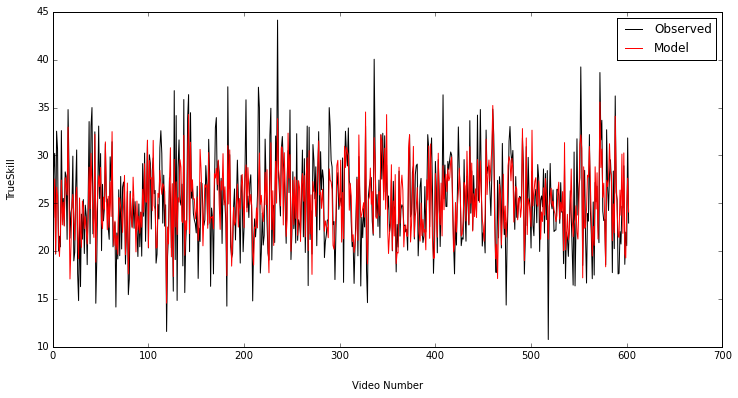

In [71]:
#plot
fig, ax = plt.subplots(figsize=(12,6))
X = range(len(y_pred))
y_tup = (y_test, y_pred)
labels=('Observed', 'Model')
colors = ('k', 'r')
for y, label, color in zip(y_tup, labels, colors):
    ax.plot(X, y, label=label, color=color)
ax.set_xlabel('Video Number', labelpad=20)
ax.set_ylabel('TrueSkill', labelpad=20)
leg = ax.legend()

In [48]:
results_array[:,:,0]

array([[[ 0.48100556,  0.48865245,  0.48337591],
        [ 0.49941763,  0.49993545,  0.49431441],
        [ 0.49390756,  0.49726437,  0.49481671]],

       [[ 0.4828344 ,  0.4876643 ,  0.48368872],
        [ 0.49872675,  0.49939517,  0.49575296],
        [ 0.49709009,  0.49993411,  0.49752857]],

       [[ 0.4730098 ,  0.47737922,  0.47661941],
        [ 0.49201415,  0.49368473,  0.49096565],
        [ 0.49553207,  0.49742334,  0.4956485 ]]])

In [49]:
np.max(results_array)

0.51155475073993972

In [50]:
np.max?

In [51]:
best_param_coords = np.unravel_index(np.argmax(results_array), results_array.shape)

In [56]:
print 'best params: \ntraj_gamma = .5\nmbhx_gamma = 1\nmbhy_gamma = 1\nhog_gamma = 1\nhof_gamma = .5'

best params: 
traj_gamma = .5
mbhx_gamma = 1
mbhy_gamma = 1
hog_gamma = 1
hof_gamma = .5


In [74]:
#save the results
with open('SVR_final_results.csv', 'wb') as f:
    import csv
    cw = csv.writer(f)
    cw.writerow(['Video_Name', 'y_test', 'y_pred'])
    for ii, name in enumerate(test_set.feature_dict['Video_Name']):
        row = [name[0], y_test[ii], y_pred[ii]]
        cw.writerow(row) 

In [75]:
#save the results
with open('SVR_training_results.csv', 'wb') as f:
    import csv
    cw = csv.writer(f)
    cw.writerow(['Video_Name', 'y_train'])
    for ii, name in enumerate(train_set.feature_dict['Video_Name']):
        row = [name[0], y_train[ii]]
        cw.writerow(row) 

In [2]:
#check that save is good
with open('SVR_final_results.csv', 'rb') as f:
    import csv
    cr = csv.reader(f)
    header = cr.next()
    y_test_check, y_pred_check = [], []
    for row in cr:
        y_test_check.append(float(row[1]))
        y_pred_check.append(float(row[2]))

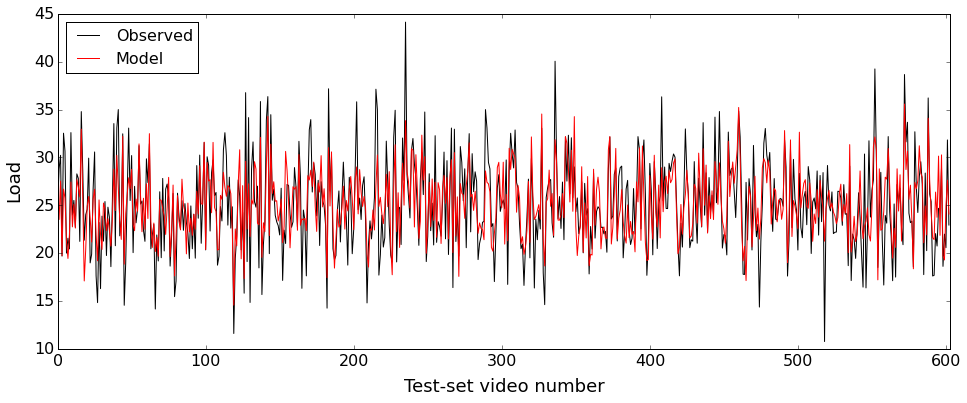

In [18]:
#plot
fig, ax = plt.subplots(figsize=(16,6))
X = range(len(y_pred_check))
y_tup = (y_test_check, y_pred_check)
labels=('Observed', 'Model')
colors = ('k', 'r')
for y, label, color in zip(y_tup, labels, colors):
    ax.plot(X, y, label=label, color=color)
ax.set_xlabel('Test-set video number', labelpad=10, fontsize=18)
ax.set_ylabel('Load', labelpad=10, fontsize=18)
ax.tick_params(labelsize=16)
ax.set_xlim((0,603))
leg = ax.legend(fontsize=16, loc=2)